In [1]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import albumentations as albu
import segmentation_models as sm
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cv2
from model import ModelCreator
from datapipeline import DatasetCreator
import shutil

Segmentation Models: using `tf.keras` framework.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
height = 512

In [4]:
modelcreator = ModelCreator()
model = modelcreator.buildmodel()
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])

KerasTensor(type_spec=TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None), name='conv2d_transpose_6/Sigmoid:0', description="created by layer 'conv2d_transpose_6'")


In [5]:
val_transforms = albu.Compose([
    albu.Resize(height, height),
    albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
valdataset = DatasetCreator(modelcreator.getpreprocess(),val_transforms)

In [7]:
valdata = valdataset('crosval/val/*png','castom-masks/masks_machine/')
len(valdata)

8

In [8]:
trainaugmentation = albu.Compose([
    albu.Resize(height, height),
    albu.HorizontalFlip(p=0.5),
    albu.VerticalFlip(p=0.5),
    albu.RandomRotate90(p=0.5),
    albu.Transpose(p=0.5),
    albu.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=15, p=0.5),
    albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
    albu.GridDistortion(p=0.5),
    albu.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    albu.RandomBrightnessContrast(p=0.5),
    albu.RandomGamma(p=0.5),
    albu.GaussianBlur(blur_limit=(3, 7), p=0.5),
    albu.GaussNoise(),
    albu.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5), 
    albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])#todo change later

In [9]:
traindataset = DatasetCreator(modelcreator.getpreprocess(),trainaugmentation)

In [10]:
traindata = traindataset('crosval/train/*png','castom-masks/masks_machine/')
len(traindata)

20

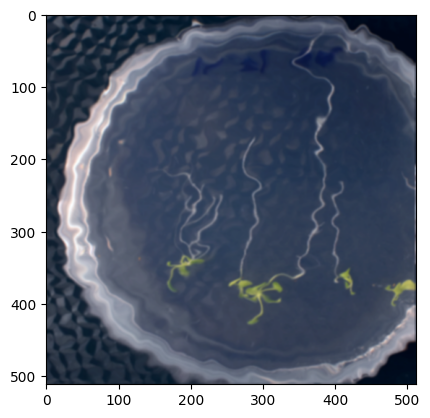

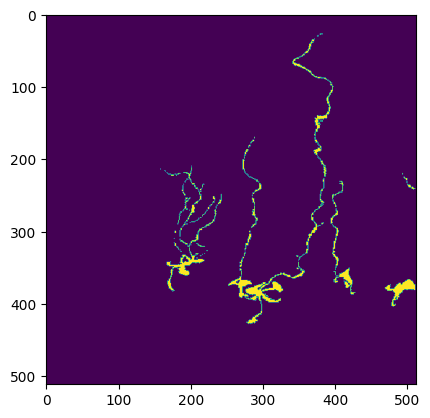

In [11]:
for image,mask in traindata.take(1):
        plt.imshow(tf.keras.utils.array_to_img(image[0]))
        plt.pause(1)
        plt.imshow(tf.keras.utils.array_to_img(mask[0]))

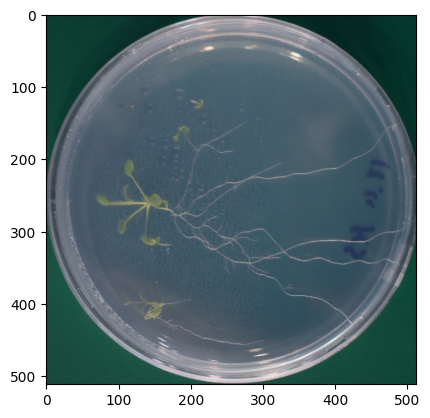

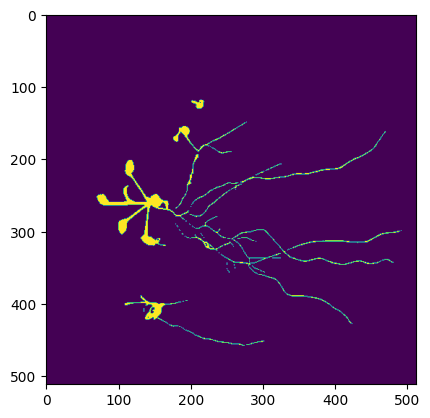

In [12]:
for image,mask in valdata.take(1):
        plt.imshow(tf.keras.utils.array_to_img(image[0]))
        plt.pause(1)
        plt.imshow(tf.keras.utils.array_to_img(mask[0]))

In [13]:
#tf.keras.utils.plot_model(model)

In [14]:
def scheduler(epoch, lr):
    return lr * tf.math.exp(-0.1) if epoch > 15 and epoch % 15 == 0 else lr

callback =[
    tf.keras.callbacks.EarlyStopping(min_delta=0.0001,patience=30,verbose=1),
    tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath='bestmodel/',save_best_only=True,monitor='val_loss',verbose=1)
]

In [15]:
# fit model
model_history = model.fit(
    traindata,
    epochs=1000,
    validation_data=valdata,
    callbacks=callback,
    )


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.


Epoch 1/1000
20/20 [==============================] - ETA: 0s - loss: 1.7456 - iou_score: 0.0089
Epoch 1: val_loss improved from inf to 1.58238, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 39s 2s/step - loss: 1.7456 - iou_score: 0.0089 - val_loss: 1.5824 - val_iou_score: 0.0086 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/1000
20/20 [==============================] - ETA: 0s - loss: 1.2177 - iou_score: 0.0098
Epoch 2: val_loss did not improve from 1.58238
20/20 [==============================] - 34s 1s/step - loss: 1.2177 - iou_score: 0.0098 - val_loss: 2.0273 - val_iou_score: 0.0073 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/1000
20/20 [==============================] - ETA: 0s - loss: 1.0990 - iou_score: 0.0120
Epoch 3: val_loss improved from 1.58238 to 1.49510, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 1.0990 - iou_score: 0.0120 - val_loss: 1.4951 - val_iou_score: 0.0081 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/1000
20/20 [==============================] - ETA: 0s - loss: 1.0602 - iou_score: 0.0155
Epoch 4: val_loss improved from 1.49510 to 1.19892, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 1.0602 - iou_score: 0.0155 - val_loss: 1.1989 - val_iou_score: 0.0088 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/1000
20/20 [==============================] - ETA: 0s - loss: 1.0386 - iou_score: 0.0278
Epoch 5: val_loss improved from 1.19892 to 1.15656, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 1.0386 - iou_score: 0.0278 - val_loss: 1.1566 - val_iou_score: 0.0093 - lr: 0.0010

Epoch 6: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 6/1000
20/20 [==============================] - ETA: 0s - loss: 1.0330 - iou_score: 0.0313
Epoch 6: val_loss improved from 1.15656 to 1.12834, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 1.0330 - iou_score: 0.0313 - val_loss: 1.1283 - val_iou_score: 0.0087 - lr: 0.0010

Epoch 7: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 7/1000
20/20 [==============================] - ETA: 0s - loss: 1.0089 - iou_score: 0.0514
Epoch 7: val_loss did not improve from 1.12834
20/20 [==============================] - 33s 1s/step - loss: 1.0089 - iou_score: 0.0514 - val_loss: 1.1421 - val_iou_score: 0.0086 - lr: 0.0010

Epoch 8: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 8/1000
20/20 [==============================] - ETA: 0s - loss: 1.0058 - iou_score: 0.0519
Epoch 8: val_loss improved from 1.12834 to 1.08482, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 1.0058 - iou_score: 0.0519 - val_loss: 1.0848 - val_iou_score: 0.0090 - lr: 0.0010

Epoch 9: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 9/1000
20/20 [==============================] - ETA: 0s - loss: 0.9678 - iou_score: 0.0816
Epoch 9: val_loss improved from 1.08482 to 1.06446, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.9678 - iou_score: 0.0816 - val_loss: 1.0645 - val_iou_score: 0.0087 - lr: 0.0010

Epoch 10: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 10/1000
20/20 [==============================] - ETA: 0s - loss: 0.9684 - iou_score: 0.0807
Epoch 10: val_loss improved from 1.06446 to 1.05657, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.9684 - iou_score: 0.0807 - val_loss: 1.0566 - val_iou_score: 0.0086 - lr: 0.0010

Epoch 11: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 11/1000
20/20 [==============================] - ETA: 0s - loss: 0.9313 - iou_score: 0.1112
Epoch 11: val_loss improved from 1.05657 to 1.05037, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.9313 - iou_score: 0.1112 - val_loss: 1.0504 - val_iou_score: 0.0080 - lr: 0.0010

Epoch 12: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 12/1000
20/20 [==============================] - ETA: 0s - loss: 0.9003 - iou_score: 0.1418
Epoch 12: val_loss improved from 1.05037 to 1.04644, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.9003 - iou_score: 0.1418 - val_loss: 1.0464 - val_iou_score: 0.0084 - lr: 0.0010

Epoch 13: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 13/1000
20/20 [==============================] - ETA: 0s - loss: 0.8697 - iou_score: 0.1662
Epoch 13: val_loss improved from 1.04644 to 1.04284, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.8697 - iou_score: 0.1662 - val_loss: 1.0428 - val_iou_score: 0.0090 - lr: 0.0010

Epoch 14: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 14/1000
20/20 [==============================] - ETA: 0s - loss: 0.8137 - iou_score: 0.2213
Epoch 14: val_loss improved from 1.04284 to 1.03906, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.8137 - iou_score: 0.2213 - val_loss: 1.0391 - val_iou_score: 0.0097 - lr: 0.0010

Epoch 15: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 15/1000
20/20 [==============================] - ETA: 0s - loss: 0.7926 - iou_score: 0.2467
Epoch 15: val_loss improved from 1.03906 to 1.03581, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.7926 - iou_score: 0.2467 - val_loss: 1.0358 - val_iou_score: 0.0142 - lr: 0.0010

Epoch 16: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 16/1000
20/20 [==============================] - ETA: 0s - loss: 0.7220 - iou_score: 0.3128
Epoch 16: val_loss improved from 1.03581 to 1.02175, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.7220 - iou_score: 0.3128 - val_loss: 1.0218 - val_iou_score: 0.0231 - lr: 0.0010

Epoch 17: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 17/1000
20/20 [==============================] - ETA: 0s - loss: 0.7516 - iou_score: 0.2878
Epoch 17: val_loss improved from 1.02175 to 1.01000, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.7516 - iou_score: 0.2878 - val_loss: 1.0100 - val_iou_score: 0.0336 - lr: 0.0010

Epoch 18: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 18/1000
20/20 [==============================] - ETA: 0s - loss: 0.7266 - iou_score: 0.3077 
Epoch 18: val_loss improved from 1.01000 to 0.99007, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 591s 31s/step - loss: 0.7266 - iou_score: 0.3077 - val_loss: 0.9901 - val_iou_score: 0.0524 - lr: 0.0010

Epoch 19: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 19/1000
20/20 [==============================] - ETA: 0s - loss: 0.7201 - iou_score: 0.3150
Epoch 19: val_loss improved from 0.99007 to 0.98578, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.7201 - iou_score: 0.3150 - val_loss: 0.9858 - val_iou_score: 0.0527 - lr: 0.0010

Epoch 20: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 20/1000
20/20 [==============================] - ETA: 0s - loss: 0.7117 - iou_score: 0.3269
Epoch 20: val_loss improved from 0.98578 to 0.90780, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.7117 - iou_score: 0.3269 - val_loss: 0.9078 - val_iou_score: 0.1209 - lr: 0.0010

Epoch 21: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 21/1000
20/20 [==============================] - ETA: 0s - loss: 0.6749 - iou_score: 0.3601
Epoch 21: val_loss improved from 0.90780 to 0.85105, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.6749 - iou_score: 0.3601 - val_loss: 0.8510 - val_iou_score: 0.1711 - lr: 0.0010

Epoch 22: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 22/1000
20/20 [==============================] - ETA: 0s - loss: 0.6952 - iou_score: 0.3440
Epoch 22: val_loss improved from 0.85105 to 0.81301, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.6952 - iou_score: 0.3440 - val_loss: 0.8130 - val_iou_score: 0.2155 - lr: 0.0010

Epoch 23: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 23/1000
20/20 [==============================] - ETA: 0s - loss: 0.6643 - iou_score: 0.3731
Epoch 23: val_loss did not improve from 0.81301
20/20 [==============================] - 33s 1s/step - loss: 0.6643 - iou_score: 0.3731 - val_loss: 0.8357 - val_iou_score: 0.1963 - lr: 0.0010

Epoch 24: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 24/1000
20/20 [==============================] - ETA: 0s - loss: 0.6649 - iou_score: 0.3707
Epoch 24: val_loss did not improve from 0.81301
20/20 [==============================] - 33s 1s/step - loss: 0.6649 - iou_score: 0.3707 - val_loss: 0.8581 - val_iou_score: 0.1879 - lr: 0.0010

Epoch 25: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 25/1000
20/20 [============

INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.6757 - iou_score: 0.3623 - val_loss: 0.7697 - val_iou_score: 0.2639 - lr: 0.0010

Epoch 26: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 26/1000
20/20 [==============================] - ETA: 0s - loss: 0.6610 - iou_score: 0.3729
Epoch 26: val_loss improved from 0.76972 to 0.71291, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.6610 - iou_score: 0.3729 - val_loss: 0.7129 - val_iou_score: 0.3201 - lr: 0.0010

Epoch 27: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 27/1000
20/20 [==============================] - ETA: 0s - loss: 0.6673 - iou_score: 0.3678
Epoch 27: val_loss improved from 0.71291 to 0.69290, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.6673 - iou_score: 0.3678 - val_loss: 0.6929 - val_iou_score: 0.3331 - lr: 0.0010

Epoch 28: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 28/1000
20/20 [==============================] - ETA: 0s - loss: 0.6150 - iou_score: 0.4200
Epoch 28: val_loss improved from 0.69290 to 0.66022, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.6150 - iou_score: 0.4200 - val_loss: 0.6602 - val_iou_score: 0.3705 - lr: 0.0010

Epoch 29: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 29/1000
20/20 [==============================] - ETA: 0s - loss: 0.6521 - iou_score: 0.3862
Epoch 29: val_loss improved from 0.66022 to 0.61504, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.6521 - iou_score: 0.3862 - val_loss: 0.6150 - val_iou_score: 0.4182 - lr: 0.0010

Epoch 30: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 30/1000
20/20 [==============================] - ETA: 0s - loss: 0.6291 - iou_score: 0.4075
Epoch 30: val_loss improved from 0.61504 to 0.60210, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.6291 - iou_score: 0.4075 - val_loss: 0.6021 - val_iou_score: 0.4270 - lr: 0.0010

Epoch 31: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 31/1000
20/20 [==============================] - ETA: 0s - loss: 0.6399 - iou_score: 0.3994
Epoch 31: val_loss improved from 0.60210 to 0.58220, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.6399 - iou_score: 0.3994 - val_loss: 0.5822 - val_iou_score: 0.4444 - lr: 9.0484e-04

Epoch 32: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 32/1000
20/20 [==============================] - ETA: 0s - loss: 0.6521 - iou_score: 0.3852
Epoch 32: val_loss improved from 0.58220 to 0.55361, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.6521 - iou_score: 0.3852 - val_loss: 0.5536 - val_iou_score: 0.4745 - lr: 9.0484e-04

Epoch 33: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 33/1000
20/20 [==============================] - ETA: 0s - loss: 0.6157 - iou_score: 0.4191
Epoch 33: val_loss did not improve from 0.55361
20/20 [==============================] - 34s 1s/step - loss: 0.6157 - iou_score: 0.4191 - val_loss: 0.5585 - val_iou_score: 0.4687 - lr: 9.0484e-04

Epoch 34: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 34/1000
20/20 [==============================] - ETA: 0s - loss: 0.6224 - iou_score: 0.4141
Epoch 34: val_loss improved from 0.55361 to 0.53941, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.6224 - iou_score: 0.4141 - val_loss: 0.5394 - val_iou_score: 0.4858 - lr: 9.0484e-04

Epoch 35: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 35/1000
20/20 [==============================] - ETA: 0s - loss: 0.5912 - iou_score: 0.4426
Epoch 35: val_loss improved from 0.53941 to 0.51134, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.5912 - iou_score: 0.4426 - val_loss: 0.5113 - val_iou_score: 0.5083 - lr: 9.0484e-04

Epoch 36: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 36/1000
20/20 [==============================] - ETA: 0s - loss: 0.6102 - iou_score: 0.4278
Epoch 36: val_loss did not improve from 0.51134
20/20 [==============================] - 33s 1s/step - loss: 0.6102 - iou_score: 0.4278 - val_loss: 0.5265 - val_iou_score: 0.4985 - lr: 9.0484e-04

Epoch 37: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 37/1000
20/20 [==============================] - ETA: 0s - loss: 0.6088 - iou_score: 0.4257
Epoch 37: val_loss did not improve from 0.51134
20/20 [==============================] - 34s 1s/step - loss: 0.6088 - iou_score: 0.4257 - val_loss: 0.5397 - val_iou_score: 0.4892 - lr: 9.0484e-04

Epoch 38: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 38/1000
20/20 [

INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.6362 - iou_score: 0.4010 - val_loss: 0.4849 - val_iou_score: 0.5376 - lr: 9.0484e-04

Epoch 40: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 40/1000
20/20 [==============================] - ETA: 0s - loss: 0.6191 - iou_score: 0.4194
Epoch 40: val_loss improved from 0.48491 to 0.48331, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.6191 - iou_score: 0.4194 - val_loss: 0.4833 - val_iou_score: 0.5501 - lr: 9.0484e-04

Epoch 41: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 41/1000
20/20 [==============================] - ETA: 0s - loss: 0.6217 - iou_score: 0.4164
Epoch 41: val_loss did not improve from 0.48331
20/20 [==============================] - 33s 1s/step - loss: 0.6217 - iou_score: 0.4164 - val_loss: 0.4847 - val_iou_score: 0.5397 - lr: 9.0484e-04

Epoch 42: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 42/1000
20/20 [==============================] - ETA: 0s - loss: 0.6055 - iou_score: 0.4299
Epoch 42: val_loss did not improve from 0.48331
20/20 [==============================] - 33s 1s/step - loss: 0.6055 - iou_score: 0.4299 - val_loss: 0.5091 - val_iou_score: 0.5207 - lr: 9.0484e-04

Epoch 43: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 43/1000
20/20 [

INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.6113 - iou_score: 0.4242 - val_loss: 0.4811 - val_iou_score: 0.5487 - lr: 9.0484e-04

Epoch 45: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 45/1000
20/20 [==============================] - ETA: 0s - loss: 0.6045 - iou_score: 0.4339
Epoch 45: val_loss improved from 0.48111 to 0.46443, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.6045 - iou_score: 0.4339 - val_loss: 0.4644 - val_iou_score: 0.5578 - lr: 9.0484e-04

Epoch 46: LearningRateScheduler setting learning rate to 0.0008187307976186275.
Epoch 46/1000
20/20 [==============================] - ETA: 0s - loss: 0.6020 - iou_score: 0.4350
Epoch 46: val_loss did not improve from 0.46443
20/20 [==============================] - 33s 1s/step - loss: 0.6020 - iou_score: 0.4350 - val_loss: 0.4957 - val_iou_score: 0.5359 - lr: 8.1873e-04

Epoch 47: LearningRateScheduler setting learning rate to 0.0008187307976186275.
Epoch 47/1000
20/20 [==============================] - ETA: 0s - loss: 0.5878 - iou_score: 0.4480
Epoch 47: val_loss did not improve from 0.46443
20/20 [==============================] - 33s 1s/step - loss: 0.5878 - iou_score: 0.4480 - val_loss: 0.4904 - val_iou_score: 0.5379 - lr: 8.1873e-04

Epoch 48: LearningRateScheduler setting learning rate to 0.0008187307976186275.
Epoch 48/1000
20/20 [

INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.5710 - iou_score: 0.4616 - val_loss: 0.4615 - val_iou_score: 0.5615 - lr: 8.1873e-04

Epoch 57: LearningRateScheduler setting learning rate to 0.0008187307976186275.
Epoch 57/1000


2023-10-03 23:03:30.528220: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 62 of 100
2023-10-03 23:03:30.715504: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 63 of 100
2023-10-03 23:03:30.832171: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 64 of 100
2023-10-03 23:03:30.887339: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 65 of 100
2023-10-03 23:03:31.011288: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 66 of 100
2023-10-03 23:03:31.070824: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 67 of 100
2023-10-03 23:03:31.172029: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this 

20/20 [==============================] - ETA: 0s - loss: 0.5925 - iou_score: 0.4427
Epoch 57: val_loss improved from 0.46148 to 0.45674, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 212s 2s/step - loss: 0.5925 - iou_score: 0.4427 - val_loss: 0.4567 - val_iou_score: 0.5613 - lr: 8.1873e-04

Epoch 58: LearningRateScheduler setting learning rate to 0.0008187307976186275.
Epoch 58/1000
20/20 [==============================] - ETA: 0s - loss: 0.5988 - iou_score: 0.4377
Epoch 58: val_loss improved from 0.45674 to 0.44657, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.5988 - iou_score: 0.4377 - val_loss: 0.4466 - val_iou_score: 0.5785 - lr: 8.1873e-04

Epoch 59: LearningRateScheduler setting learning rate to 0.0008187307976186275.
Epoch 59/1000
20/20 [==============================] - ETA: 0s - loss: 0.5953 - iou_score: 0.4396
Epoch 59: val_loss did not improve from 0.44657
20/20 [==============================] - 34s 1s/step - loss: 0.5953 - iou_score: 0.4396 - val_loss: 0.4755 - val_iou_score: 0.5566 - lr: 8.1873e-04

Epoch 60: LearningRateScheduler setting learning rate to 0.0008187307976186275.
Epoch 60/1000
20/20 [==============================] - ETA: 0s - loss: 0.5850 - iou_score: 0.4515
Epoch 60: val_loss did not improve from 0.44657
20/20 [==============================] - 33s 1s/step - loss: 0.5850 - iou_score: 0.4515 - val_loss: 0.4742 - val_iou_score: 0.5540 - lr: 8.1873e-04

Epoch 61: LearningRateScheduler setting learning rate to 0.0007408182718791068.
Epoch 61/1000
20/20 [

INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.5694 - iou_score: 0.4665 - val_loss: 0.4457 - val_iou_score: 0.5792 - lr: 7.4082e-04

Epoch 65: LearningRateScheduler setting learning rate to 0.0007408182718791068.
Epoch 65/1000
20/20 [==============================] - ETA: 0s - loss: 0.5779 - iou_score: 0.4574
Epoch 65: val_loss did not improve from 0.44570
20/20 [==============================] - 33s 1s/step - loss: 0.5779 - iou_score: 0.4574 - val_loss: 0.4641 - val_iou_score: 0.5618 - lr: 7.4082e-04

Epoch 66: LearningRateScheduler setting learning rate to 0.0007408182718791068.
Epoch 66/1000
20/20 [==============================] - ETA: 0s - loss: 0.5858 - iou_score: 0.4509
Epoch 66: val_loss improved from 0.44570 to 0.42446, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.5858 - iou_score: 0.4509 - val_loss: 0.4245 - val_iou_score: 0.5987 - lr: 7.4082e-04

Epoch 67: LearningRateScheduler setting learning rate to 0.0007408182718791068.
Epoch 67/1000
20/20 [==============================] - ETA: 0s - loss: 0.5808 - iou_score: 0.4500
Epoch 67: val_loss did not improve from 0.42446
20/20 [==============================] - 33s 1s/step - loss: 0.5808 - iou_score: 0.4500 - val_loss: 0.4489 - val_iou_score: 0.5811 - lr: 7.4082e-04

Epoch 68: LearningRateScheduler setting learning rate to 0.0007408182718791068.
Epoch 68/1000
20/20 [==============================] - ETA: 0s - loss: 0.5626 - iou_score: 0.4701
Epoch 68: val_loss did not improve from 0.42446
20/20 [==============================] - 34s 1s/step - loss: 0.5626 - iou_score: 0.4701 - val_loss: 0.4600 - val_iou_score: 0.5663 - lr: 7.4082e-04

Epoch 69: LearningRateScheduler setting learning rate to 0.0007408182718791068.
Epoch 69/1000
20/20 [

INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.5432 - iou_score: 0.4884 - val_loss: 0.4228 - val_iou_score: 0.5966 - lr: 6.0653e-04

Epoch 95: LearningRateScheduler setting learning rate to 0.0006065307534299791.
Epoch 95/1000
20/20 [==============================] - ETA: 0s - loss: 0.5544 - iou_score: 0.4772
Epoch 95: val_loss improved from 0.42279 to 0.41159, saving model to bestmodel/
INFO:tensorflow:Assets written to: bestmodel/assets


INFO:tensorflow:Assets written to: bestmodel/assets


20/20 [==============================] - 37s 2s/step - loss: 0.5544 - iou_score: 0.4772 - val_loss: 0.4116 - val_iou_score: 0.6058 - lr: 6.0653e-04

Epoch 96: LearningRateScheduler setting learning rate to 0.0006065307534299791.
Epoch 96/1000
20/20 [==============================] - ETA: 0s - loss: 0.5611 - iou_score: 0.4718
Epoch 96: val_loss did not improve from 0.41159
20/20 [==============================] - 33s 1s/step - loss: 0.5611 - iou_score: 0.4718 - val_loss: 0.4751 - val_iou_score: 0.5525 - lr: 6.0653e-04

Epoch 97: LearningRateScheduler setting learning rate to 0.0006065307534299791.
Epoch 97/1000
20/20 [==============================] - ETA: 0s - loss: 0.5611 - iou_score: 0.4720
Epoch 97: val_loss did not improve from 0.41159
20/20 [==============================] - 33s 1s/step - loss: 0.5611 - iou_score: 0.4720 - val_loss: 0.4504 - val_iou_score: 0.5705 - lr: 6.0653e-04

Epoch 98: LearningRateScheduler setting learning rate to 0.0006065307534299791.
Epoch 98/1000
20/20 [

In [16]:
testdata = valdataset('crosval/test/*png','castom-masks/masks_machine/',batch_size=1)

In [17]:
results = model.evaluate(testdata)
results

9/9 [==============================] - 2s 102ms/step - loss: 0.4432 - iou_score: 0.5895


[0.4431629776954651, 0.5894734263420105]

In [18]:
i = 0

if os.path.isdir('output/'):
    shutil.rmtree('output/')
os.makedirs('output/')

for image,truemask in testdata.take(len(testdata)):
    mask = model.predict((tf.reshape(image,[1,height,height,3])))
    mask = tf.keras.utils.array_to_img(mask[0])
    img = tf.keras.utils.array_to_img(image[0])
    img = cv2.cvtColor(np.array(img),cv2.COLOR_BGR2RGB)
    mask = cv2.cvtColor(np.array(mask),cv2.COLOR_GRAY2RGB)
    vis = np.concatenate((img, mask), axis=1)
    i+=1
    cv2.imwrite('output/'+str(i)+'.png', vis)

1/1 [==============================] - 0s 105ms/step


In [ ]:
testdata = valdataset('crosval/test/*png','castom-masks/masks_machine/',batch_size=1)

i = 0

if os.path.isdir('testall/'):
    shutil.rmtree('testall/')
os.makedirs('testall/')

for image,truemask in testdata.take(len(testdata)):
    mask = model.predict((tf.reshape(image,[1,height,height,3])))
    mask = tf.keras.utils.array_to_img(mask[0])
    img = tf.keras.utils.array_to_img(image[0])
    img = cv2.cvtColor(np.array(img),cv2.COLOR_BGR2RGB)
    mask = cv2.cvtColor(np.array(mask),cv2.COLOR_GRAY2RGB)
    vis = np.concatenate((img, mask), axis=1)
    i+=1
    cv2.imwrite('testall/'+str(i)+'.png', vis)